# Banking Marketing Targets

Tushar (tk22994)

Nandu ()

Mehdi (ma57795)

Sean (sha567)

## Introduction

You will submit a Jupyter Notebook that walks a reader through your analysis. The notebook should effectively communicate the "story" of your data analysis: not just what you found, but how you found it.

You should start with a brief introduction to the problem (utilize markdown cells for this). What is the data science problem you are trying to solve? Why does the problem matter? What could the results of your predictive model be used for? Why would we want to be able to predict the thing you’re trying to predict? Then describe the dataset that you will use to tackle this problem.

Given direct marketing campaign data from a Portuguese banking institution, can we predict if a client will subscribe to a term deposit?

A term deposit is a fixed-term investment that includes the deposit of money into an account at a financial institution. These investments usually carry short-term maturities ranging from just a month, to a couple years. A client's money is invested for a certain rate of interest over the whole term.

Term deposits also happen to be a significant source of income for banks. One way that banks will advertise term deposits is through telephonic marketing, which is considered to be one of the more viable marketing methods. However, telephonic marketing campaigns generate large costs through the hiring of call centers. Therefore, it is financially prudent for banks to figure out which customers are the most likely to convert first, and then proceed with targeting them with telephonic marketing after.

So people that are more educated - tertiary for example - and in management roles may have the education to disregard direct marketing calls. They are more likely to regard them as spam or scam calls. It is also more likely then that they prefer other investments, like stocks for example that have a higher rate of return but maybe a bit less safe. 

## data science
From here, proceed with the data science. Perform data cleaning, data exploration, feature engineering, etc. Use the markdown cells to describe and clarify each part of the process, so that a reader can easily follow along with what you've done.

In [15]:
# import libraries/ standard headers
import numpy as np
import pandas as pd

# enable inline mode for matplotlib so that Jupyter displays graphs
%matplotlib inline

# pandas version we're using
pd.__version__ 

'1.3.4'

### data cleaning
Perform data cleaning. Data cleaning is the process of trying to detect and correct data quality issues
Data quality issues
* missing values
* errors/inconsistent values
* duplicate values
* noise and outliers

In [24]:
# read in the dataset
train_df = pd.read_csv("dataset/train.csv", sep=";")
test_df = pd.read_csv("dataset/test.csv", sep=";")

train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [17]:
# how many missing values are there in both the train and test 
# datasets?
train_df.isnull().sum()
test_df.isnull().sum()


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

As you can see above there are 0 missing values in each column of the train and test sets. So we don't have to fill in the missing values with something reasonable, imputing - with the mean of the column for example

### exploratory data analysis (eda)
Perform data exploration
#### Noise vs outliers
* outliers - anomalous objects with characteristics that are different from, or unusual with respect to, the rest of the data
* noise - random errors in the data

<AxesSubplot:xlabel='job', ylabel='age'>

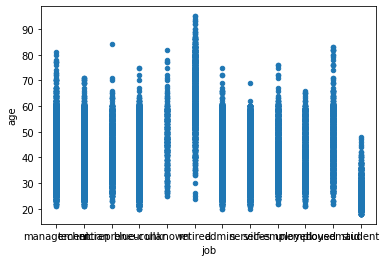

In [25]:
# create a scatterplot between age and job
train_df.plot.scatter('job', 'age')

<AxesSubplot:xlabel='job', ylabel='age'>

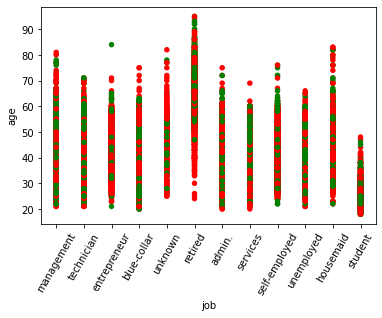

In [29]:
colors = {'no': 'red', 'yes': 'green'}
train_df.plot.scatter('job', 'age', c=train_df['y'].map(colors), rot=60)

retired folks seem more likely to invest in low risk securities!

### feature engineering
perform feature engineering

## modeling
Then move on to the modeling, and continue to use the markdown cells to walk a reader through your  process. 

## results
Finally, display and analyze your results.

### conclusion
Include a final conclusion - this may be an analysis of which model worked best, or which feature engineering worked best, or it may be any interesting insights you discovered about your data, or anything at all that you want to conclude from your work. 